In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version xgboost: {xgb.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version xgboost: 1.7.6
- Version pandas: 2.2.3
- Version numpy: 1.26.4
- Version sklearn: 2.2.3


In [2]:
try:
    data = pd.read_csv('../Datasets/datasetMulti.csv')
except FileNotFoundError:
    print("Error: El archivo '../Datasets/datasetMulti.csv' no fue encontrado.")
    exit()

print("Primeras filas del dataset:")
print(data.head())

Primeras filas del dataset:
    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N  


In [3]:
data = data.drop(columns=['ID', 'No_Pation'])

class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data['CLASS'] = data['CLASS'].map(class_mapping)

data = pd.get_dummies(data, columns=['Gender'], drop_first=True)

data.dropna(inplace=True)

data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento listo. Nuevas columnas:")
print(data.columns)
data.head()

Preprocesamiento listo. Nuevas columnas:
Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'CLASS', 'Gender_M', 'Gender_f'],
      dtype='object')


,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS,Gender_M,Gender_f
0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0.0,False,False
1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0.0,True,False
2,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0.0,False,False
3,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0.0,False,False
4,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0.0,True,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 995
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       995 non-null    int64  
 1   Urea      995 non-null    float64
 2   Cr        995 non-null    int64  
 3   HbA1c     995 non-null    float64
 4   Chol      995 non-null    float64
 5   TG        995 non-null    float64
 6   HDL       995 non-null    float64
 7   LDL       995 non-null    float64
 8   VLDL      995 non-null    float64
 9   BMI       995 non-null    float64
 10  CLASS     995 non-null    float64
 11  Gender_M  995 non-null    bool   
 12  Gender_f  995 non-null    bool   
dtypes: bool(2), float64(9), int64(2)
memory usage: 95.2 KB


In [5]:
class_0 = data[data['CLASS'] == 0].sample(n=50, random_state=42) 
class_1 = data[data['CLASS'] == 1].sample(n=50, random_state=42)
class_2 = data[data['CLASS'] == 2].sample(n=50, random_state=42) 
balanced_train_data = pd.concat([class_0, class_1,class_2]).sample(frac=1, random_state=42).reset_index(drop=True)
print("--- Distribución de clases en la muestra del 10% ---")
print(balanced_train_data['CLASS'].value_counts())
print("-" * 50)

--- Distribución de clases en la muestra del 10% ---
CLASS
1.0    50
0.0    50
2.0    50
Name: count, dtype: int64
--------------------------------------------------


In [6]:
balanced_train_data

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS,Gender_M,Gender_f
0,50,4.3,59,6.1,4.0,3.0,1.0,1.8,1.3,24.0,1.0,True,False
1,30,3.0,42,4.1,4.9,1.3,1.2,3.2,0.5,22.0,0.0,False,False
2,55,5.0,76,10.2,5.6,4.6,0.8,2.9,31.8,33.9,2.0,True,False
3,34,3.9,81,6.0,6.2,3.9,0.8,1.9,1.8,23.0,1.0,True,False
4,50,4.8,62,5.9,5.3,1.3,1.0,3.7,0.6,25.0,1.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,42,5.4,53,5.8,5.9,3.7,1.3,3.1,1.7,23.0,1.0,True,False
146,60,6.4,83,12.3,4.0,1.9,0.7,2.6,0.9,31.0,2.0,True,False
147,35,3.3,44,5.0,4.1,1.9,4.0,1.3,0.7,23.0,0.0,False,False
148,50,4.7,53,6.1,4.2,2.2,0.8,2.5,0.9,25.0,1.0,True,False


In [7]:
data_sample = balanced_train_data

x = data_sample.drop(columns="CLASS").to_numpy()
y = data_sample["CLASS"].to_numpy()


In [8]:
clf = imbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier())])

In [15]:
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

In [16]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


In [17]:
y_pred = grid_search.predict(x_test)

Model Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           N       0.91      1.00      0.95        10
           P       0.91      1.00      0.95        10
           Y       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



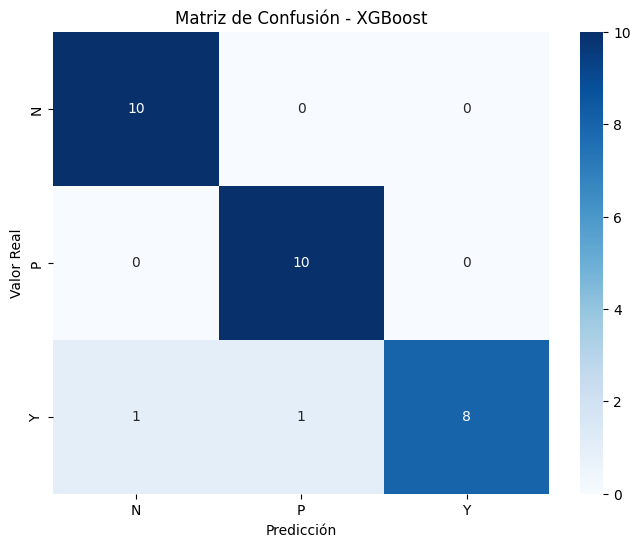

In [18]:
print('Model Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['N', 'P', 'Y']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
class_names = ['N', 'P', 'Y']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()